In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# read data and create train and test text files
import pandas as pd
import re
from sklearn.model_selection import train_test_split

df = pd.read_csv('/content/drive/MyDrive/gproject/Food Ingredients and Recipe Dataset with Image Name Mapping.csv')
def create_text_files(df, dest_path):
    with open(dest_path, 'w') as f:
        data = ''
        for texts in df.iterrows():
            ingredients  = str(texts[1]['Ingredients']).strip()[1:-1]
            instructions = str(texts[1]['Instructions']).strip()

            ingredients = re.sub(r"\s", " ", ingredients)
            instructions = re.sub(r"\s", " ", instructions)

            summary = 'Ingredients: ' + ingredients + '\nInstructions: ' + instructions
            data += summary + "\n"
        f.write(data)

train, test = train_test_split(df,test_size=0.15)
train_path = '/content/drive/MyDrive/gproject/train_dataset.txt'
test_path = '/content/drive/MyDrive/gproject/test_dataset.txt'

print("Train dataset length: "+str(len(train)))
print("Test dataset length: "+ str(len(test)))

Train dataset length: 11475
Test dataset length: 2026


In [7]:
# load the data into huggingface datasets and create model and tokenizer
from transformers import TextDataset,DataCollatorForLanguageModeling
from transformers import AutoTokenizer, Trainer, TrainingArguments, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
model = AutoModelForCausalLM.from_pretrained("openai-community/gpt2")

train_path = '/content/drive/MyDrive/gproject/train_dataset.txt'
test_path = '/content/drive/MyDrive/gproject/test_dataset.txt'

train_dataset = TextDataset(
    tokenizer=tokenizer,
    file_path=train_path,
    block_size=128
)

test_dataset = TextDataset(
    tokenizer=tokenizer,
    file_path=test_path,
    block_size=128
)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=False,
)

/usr/local/lib/python3.10/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


In [8]:
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/gproject/gpt2-recipe",
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_dir="/content/drive/MyDrive/gproject/logs",
    save_strategy='no',
    eval_strategy="epoch",
    logging_steps=100,
    warmup_steps=200,
    weight_decay=0.1,
    logging_first_step=True,
    report_to="none"
)

In [11]:
# training step
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/gproject/gpt2-recipe",
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_dir='/content/drive/MyDrive/gproject/logs',
    save_strategy='no',
    eval_strategy="epoch",
    logging_steps=100,
    warmup_steps=200,
    weight_decay=0.1,
    logging_first_step=True,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
)

initial_validation = trainer.evaluate()
trainer.train()
final_validation = trainer.evaluate()

print(f"Initial validation loss: {initial_validation['eval_loss']}")
print(f"Final validation loss: {final_validation['eval_loss']}")

Epoch,Training Loss,Validation Loss,Model Preparation Time
1,1.819600,1.838445,0.003800
2,1.819200,1.784423,0.003800
3,1.728800,1.756127,0.003800
4,1.700900,1.744631,0.003800
5,1.690200,1.737117,0.003800


Initial validation loss: 1.9127570390701294
Final validation loss: 1.7371169328689575


In [12]:
log_history = trainer.state.log_history
log_history

[{'loss': 1.9491,
  'grad_norm': 1.8284271955490112,
  'learning_rate': 2.5000000000000004e-07,
  'epoch': 0.0004878048780487805,
  'step': 1},
 {'loss': 1.9473,
  'grad_norm': 1.9348139762878418,
  'learning_rate': 2.5e-05,
  'epoch': 0.04878048780487805,
  'step': 100},
 {'loss': 1.9416,
  'grad_norm': 1.8107860088348389,
  'learning_rate': 5e-05,
  'epoch': 0.0975609756097561,
  'step': 200},
 {'loss': 1.9248,
  'grad_norm': 1.763037085533142,
  'learning_rate': 4.950248756218906e-05,
  'epoch': 0.14634146341463414,
  'step': 300},
 {'loss': 1.9065,
  'grad_norm': 1.763690710067749,
  'learning_rate': 4.900497512437811e-05,
  'epoch': 0.1951219512195122,
  'step': 400},
 {'loss': 1.9009,
  'grad_norm': 1.645447015762329,
  'learning_rate': 4.850746268656717e-05,
  'epoch': 0.24390243902439024,
  'step': 500},
 {'loss': 1.9062,
  'grad_norm': 1.756096363067627,
  'learning_rate': 4.800995024875622e-05,
  'epoch': 0.2926829268292683,
  'step': 600},
 {'loss': 1.8772,
  'grad_norm': 1.

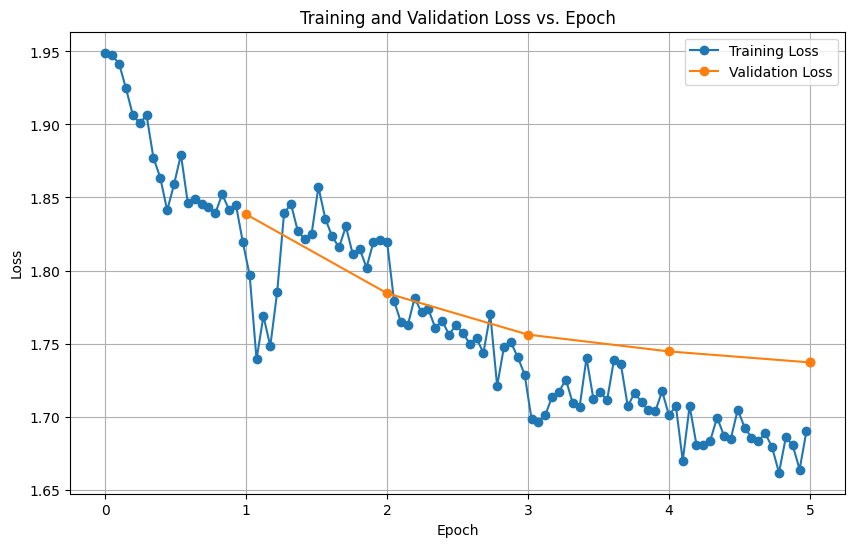

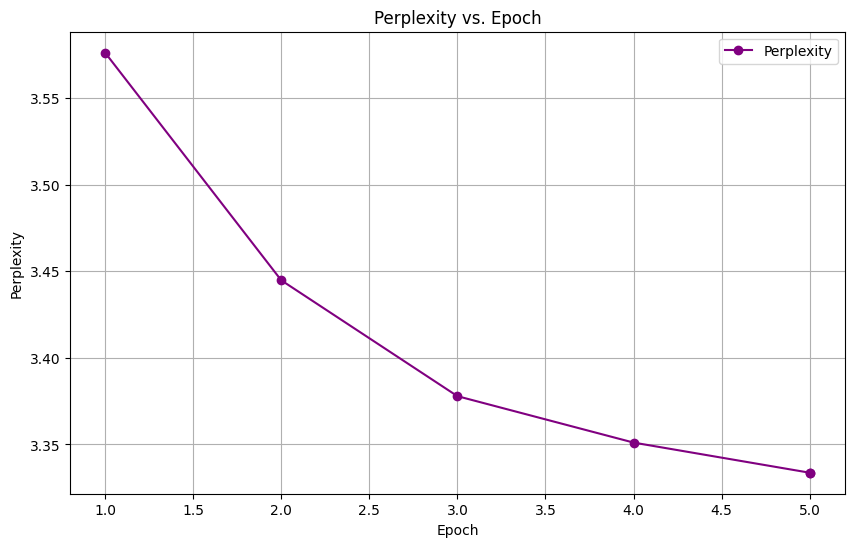

In [14]:
import matplotlib.pyplot as plt

log_history = trainer.state.log_history
log_df = pd.DataFrame(log_history)
train_loss = log_df[log_df['loss'].notnull()][['epoch', 'loss']]
val_loss = log_df[log_df['eval_loss'].notnull()][['epoch', 'eval_loss']]
val_loss['perplexity'] = val_loss['eval_loss'].apply(lambda x: 2 ** x)
plt.figure(figsize=(10, 6))
plt.plot(train_loss['epoch'], train_loss['loss'], label='Training Loss', marker='o')
plt.plot(val_loss['epoch'], val_loss['eval_loss'], label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs. Epoch')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(val_loss['epoch'], val_loss['perplexity'], label='Perplexity', marker='o', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Perplexity vs. Epoch')
plt.legend()
plt.grid(True)
plt.show()


In [18]:
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/gproject/gpt2-recipe",
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir='/content/drive/MyDrive/gproject/logs',
    save_strategy='no',
    eval_strategy="epoch",
    logging_steps=100,
    warmup_steps=00,
    weight_decay=0.01,
    logging_first_step=True,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
)

initial_validation = trainer.evaluate()
trainer.train()
final_validation = trainer.evaluate()

print(f"Initial validation loss: {initial_validation['eval_loss']}")
print(f"Final validation loss: {final_validation['eval_loss']}")

Epoch,Training Loss,Validation Loss,Model Preparation Time
1,1.724800,1.727240,0.003400
2,1.650800,1.698740,0.003400
3,1.555700,1.686409,0.003400
4,1.525900,1.683457,0.003400
5,1.509300,1.680410,0.003400


Initial validation loss: 1.7685412168502808
Final validation loss: 1.6804102659225464
